In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Geod

In [2]:
# %%
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
log = logging.getLogger(__name__)

# Optional: pandas display
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [3]:
# %%
def bearing_numpy(lat1, lon1, lat2, lon2):
    φ1 = np.radians(lat1)
    φ2 = np.radians(lat2)
    Δλ = np.radians(lon2 - lon1)

    x = np.sin(Δλ) * np.cos(φ2)
    y = np.cos(φ1) * np.sin(φ2) - np.sin(φ1) * np.cos(φ2) * np.cos(Δλ)

    θ = np.degrees(np.arctan2(x, y))  # −180…+180
    return (θ + 360) % 360          # 0…360

geod = Geod(ellps="WGS84")

In [4]:
input_csv = 'data/processed/ais/ais_data_fehmarn_radius.csv'
log.info(f"Loading AIS data from {input_csv}")
df = pd.read_csv(input_csv, parse_dates=['# Timestamp'], dtype={'MMSI': str})
df = df.sort_values(['MMSI', '# Timestamp']).reset_index(drop=True)
log.info(f"Loaded {len(df):,} rows")

2025-05-14 11:02:42,998 - INFO - Loading AIS data from data/processed/ais/ais_data_fehmarn_radius.csv
2025-05-14 11:03:27,592 - INFO - Loaded 9,843,863 rows


In [5]:
# %%
errors = []
total_pairs = 0
for mmsi, grp in df.groupby('MMSI'):
    lat = grp['Latitude'].values
    lon = grp['Longitude'].values
    if len(lat) < 2:
        continue
    # NumPy bearings for pairs
    b_np  = bearing_numpy(lat[:-1], lon[:-1], lat[1:], lon[1:])
    # pyproj.Geod.inv returns forward azimuth, back azimuth, distance
    fwd_az, _, _ = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
    b_geo = (fwd_az + 360) % 360
    # angular difference in [-180, +180]
    diff = (b_np - b_geo + 180) % 360 - 180
    errors.append(diff)
    total_pairs += len(diff)

errors = np.concatenate(errors)
log.info(f"Compared bearings for {total_pairs:,} pairs")

2025-05-14 11:04:42,356 - INFO - Compared bearings for 9,841,455 pairs


In [6]:
mean_err   = np.mean(errors)
median_err = np.median(errors)
std_err    = np.std(errors)
max_err    = np.max(np.abs(errors))

stats = pd.Series({
    'Mean error (°)': mean_err,
    'Median error (°)': median_err,
    'Std deviation (°)': std_err,
    'Max abs error (°)': max_err
})
stats

Mean error (°)      -2.204995e+01
Median error (°)    -3.272879e-08
Std deviation (°)    5.902301e+01
Max abs error (°)    1.800000e+02
dtype: float64

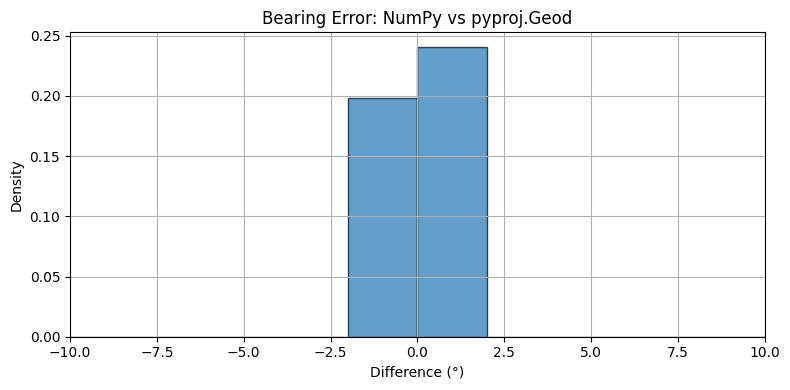

In [7]:
plt.figure(figsize=(8,4))
plt.hist(errors, bins=180, range=(-180,180), density=True,
         alpha=0.7, edgecolor='black')
plt.xlim(-10, 10)
plt.title('Bearing Error: NumPy vs pyproj.Geod')
plt.xlabel('Difference (°)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()

In [8]:
# 👩‍💻 Zirkuläre Fehleranalyse der Peilungsberechnung
import numpy as np
import pandas as pd
from scipy.stats import circmean, circstd

# --- 1) Angenommen: df enthält bereits Deine beiden Bearing-Spalten ---
#    • 'bearing_my'    – Dein eigener Peilungsalgorithmus
#    • 'bearing_gp'    – GeoPandas-/Funktion-berechnete Peilung

# 2) Rohe Differenz berechnen (kann Werte in [–360, +360] annehmen)
df['raw_diff'] = df['bearing_my'] - df['bearing_gp']

# 3) Zirkuläre Differenz: mappen auf (–180, +180]
df['error'] = (df['raw_diff'] + 180) % 360 - 180

# 4) Statistik der zirkulären Fehler
mean_circ   = circmean(df['error'], high=180, low=-180)
median_err  = df['error'].median()
std_circ    = circstd(df['error'],  high=180, low=-180)
max_abs_err = df['error'].abs().max()

# 5) Ausgabe als Pandas Series
stats = pd.Series({
    'Circular Mean (°)':      mean_circ,
    'Median Error (°)':       median_err,
    'Circular Std Dev (°)':   std_circ,
    'Max Abs Error (°)':      max_abs_err
})
print(stats.to_frame('Value').to_markdown())

# Optional: Visualisierung
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(df['error'], bins=60, edgecolor='black')
plt.xlabel('Peilungsfehler (°)')
plt.ylabel('Anzahl')
plt.title('Histogramm zirkulärer Peilungsfehler')
plt.tight_layout()
plt.show()

KeyError: 'bearing_my'

In [13]:
# %% [markdown]
# # Vergleich der Peilungsberechnung
#
# Wir berechnen die Azimut-(Bearing-)Werte von jeder AIS-Position zu unserer Antenne
# **zweimal**:
# 1. Mit unserer eigenen Formel (Haversine-Abwandlung via `atan2`)
# 2. Mit `pyproj.Geod.inv` (GeoPandas-/Proj4-Unterbau)
#
# Anschließend vergleichen wir die beiden Resultate auf ihr Residuum.

# %%
import pandas as pd
import numpy as np
import math
from pyproj import Geod
import matplotlib.pyplot as plt

# --- 1) Antennen-Koordinaten (Fehmarnbelt-Zentrum) & CSV laden ---
antenna_lat = 54.578614    # Breitengrad Antenne
antenna_lon = 11.289016    # Längengrad Antenne

df = pd.read_csv(
    "data/processed/ais/ais_data_fehmarn_radius.csv",
    parse_dates=["# Timestamp"],
    low_memory=False
)
# Falls die Spalten anders benannt sind, bitte anpassen:
lat_col = "Latitude"  # oder 'lat'
lon_col = "Longitude" # oder 'lon'
assert lat_col in df.columns and lon_col in df.columns, "Spalten für Latitude/Longitude nicht gefunden"

# --- 2) Eigene Bearing-Formel definieren ---
def bearing_custom(lat1, lon1, lat2, lon2):
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    return (θ + 360) % 360

# Vektorisierte Anwendung (kleines Sample, sonst etwas langsamer)
df = df.sample(n=50000, random_state=42).reset_index(drop=True)

df["bearing_custom"] = df.apply(
    lambda row: bearing_custom(
        antenna_lat, antenna_lon,
        row[lat_col], row[lon_col]
    ),
    axis=1
)

# --- 3) PyProj-Geod Methode ---
geod = Geod(ellps="WGS84")
# wir rufen .inv für alle Punkte einmal vektorisiert auf
az12, az21, dist = geod.inv(
    np.full(len(df), antenna_lon),
    np.full(len(df), antenna_lat),
    df[lon_col].values,
    df[lat_col].values
)
df["bearing_pyproj"] = az12 % 360

# --- 4) Fehler (Differenz) zirkulär auf (–180, +180] mappen ---
raw_diff = df["bearing_custom"] - df["bearing_pyproj"]
df["error_deg"] = (raw_diff + 180) % 360 - 180

# --- 5) Statistische Kennzahlen der Fehler ---
stats = {
    "Mean Error (°)":   df["error_deg"].mean(),
    "Median Error (°)": df["error_deg"].median(),
    "Std Dev Error (°)":df["error_deg"].std(),
    "Max Abs Error (°)":df["error_deg"].abs().max(),
}
stats_df = pd.Series(stats).to_frame("Value")
print(stats_df.to_markdown())

# --- 6) Histogramm der Peilungsdifferenzen ---
plt.figure(figsize=(6,4))
plt.hist(df["error_deg"], bins=60, edgecolor="black")
plt.title("Histogramm: Unterschied custom vs. Geod Azimuth (°)")
plt.xlabel("Fehler Δ (°)")
plt.ylabel("Anzahl Beobachtungen")
plt.tight_layout()
plt.show()

In [12]:
df

,# Timestamp,Type of mobile,MMSI,Latitude,Longitude,Navigational status,ROT,SOG,COG,Heading,IMO,Callsign,Name,Ship type,Cargo type,Width,Length,Type of position fixing device,Draught,Destination,ETA,Data source type,A,B,C,D,geometry,dist_to_port,bearing_custom,bearing_pyproj,error_deg
0,01/10/2022 21:47:12,Class A,277504000,54.443340,11.645535,Under way using engine,0.0,20.4,110.5,110.0,9350680,LYAC,ATHENA SEAWAYS,Passenger,Category Z,26.0,199.0,GPS,6.3,LTKLJ-DEKIEL-LTKLJ,02/10/2022 15:00:00,AIS,15.0,184.0,13.0,13.0,POINT (11.645535 54.44334),46887.507658,123.022323,122.962818,0.059505
1,23/10/2022 13:20:50,Class A,212018000,54.588213,10.837142,Under way using engine,0.0,12.2,265.7,265.0,9483669,5BZH2,X-PRESS ELBE,Cargo,NaN,23.0,152.0,GPS,8.4,BEANR,25/10/2022 01:00:00,AIS,141.0,11.0,12.0,11.0,POINT (10.837142 54.588213),49708.804737,272.283400,272.278664,0.004737
2,31/10/2022 22:56:55,Class A,219016665,54.655560,11.349262,Moored,0.0,0.0,47.3,47.0,9646156,OZLS2,GUARD VESSEL BOOSTER,HSC,No additional information,7.0,21.0,GPS,2.2,GUARD VESSEL FEHMARN,14/10/2022 19:00:00,AIS,14.0,7.0,5.0,2.0,POINT (11.349261999999998 54.65556),18582.370825,24.363384,24.412055,-0.048670
3,24/10/2022 16:11:18,Class A,246394000,54.504043,11.450653,Under way using engine,0.0,10.8,115.3,116.0,9137038,PEVE,LADY IRINA,Cargo,No additional information,14.0,88.0,GPS,6.0,SEVST,26/10/2022 03:00:00,AIS,75.0,13.0,3.0,11.0,POINT (11.450653 54.504043),22310.829907,128.428331,128.365112,0.063219
4,17/10/2022 18:41:03,Class A,209852000,54.578798,11.317177,Restricted maneuverability,0.0,0.0,351.4,220.0,9650212,5BVG3,NDEAVOR,Dredging,NaN,30.0,100.0,GPS,3.8,FEHMARNBELT PROJECT,15/10/2022 03:00:00,AIS,15.0,85.0,13.0,17.0,POINT (11.317177 54.578798),4502.658354,89.342637,89.344096,-0.001459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19/10/2022 07:27:27,Class A,219472000,54.568430,11.363297,Under way using engine,NaN,1.6,292.3,311.0,9686429,OWMI2,GUARDVESSEL ADVANCER,Other,NaN,8.0,23.0,GPS,1.9,GUARD VESSEL FEHMARN,27/12/2022 00:00:00,AIS,16.0,7.0,5.0,3.0,POINT (11.363297 54.568430000000006),9033.143931,103.276821,103.247822,0.029000
9996,28/10/2022 08:00:09,Class A,219000429,54.506550,11.231483,Under way using engine,8.7,8.6,26.0,27.0,9144419,OZLB2,PRINS RICHARD,Passenger,NaN,26.0,142.0,GPS,5.0,RODBY <-> PUTTGARDEN,31/12/2022 00:00:00,AIS,23.0,119.0,13.0,13.0,POINT (11.231483 54.50655),12905.274142,204.873550,204.923082,-0.049532
9997,15/10/2022 07:09:33,Class A,265413000,54.586097,10.845788,Under way using engine,0.0,12.5,263.4,264.0,9087362,SECG,SCA OSTRAND,Cargo,No additional information,24.0,170.0,GPS,6.3,KIEL,15/10/2022 10:00:00,AIS,126.0,44.0,20.0,4.0,POINT (10.845787999999999 54.586097),48717.396263,271.849268,271.845501,0.003766
9998,07/10/2022 23:43:15,Class A,255796000,54.485757,11.519013,Under way using engine,0.0,19.4,115.4,118.0,9289972,CQMN,MSC TUXPAN,Cargo,NaN,33.0,295.0,GPS,8.9,LTKLJ,09/10/2022 01:00:00,AIS,221.0,74.0,17.0,16.0,POINT (11.519013 54.485757),30628.614640,124.736265,124.675407,0.060858
